*Transfer learning* is the act of using a pre-trained network as a way to give you a huge head start on training a neural network for whatever your current application is. There are a number of canonical networks floating around, all trained on significantly-better hardware than you or I readliy have on hand, furthermore, because so many of the earlier layers are so abstract, they're often useful for whatever purpose you're designing with, out of the box.

## A Dataset

In [1]:
%pylab inline

from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test, test_size=.6, train_size=.4)

It's comprised of 60 thousand records.

In [3]:
len(x_train), len(x_dev), len(x_test)

(50000, 4000, 6000)

Where each image is `32 x 32`

In [4]:
x_train[0].shape

(32, 32, 3)

and an RGB image sampled from 10 different classes

In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

including

In [6]:
CLASSES = ['AIRPLANE', 'AUTOMOBILE', 'BIRD', 'CAT', 'DEER',
           'DOG', 'FROG', 'HORSE', 'SHIP', 'TRUCK']

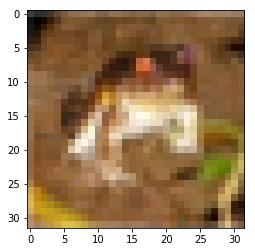

In [7]:
plt.imshow(x_train[0])

However, to predict in a multi-class fashion, we'll need to go from one column vector of integers

In [8]:
y_train.shape

(50000, 1)

To encoded representations of the same data

In [9]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [10]:
y_train.shape

(50000, 10)

## Borrowing VGG

For simplicity's sake, we're going to load [the VGG Architecture](https://napsterinblue.github.io/notes/machine_learning/computer_vision/vgg/) for our transfer learning.

It was trained on `224x244` images, targeting 10 different classes. But because our image size is of a different resolution, we can't utilize the 3 hidden layers that come with VGG (hence the arguments below).

In [11]:
from keras.applications.vgg16 import VGG16

model = VGG16(input_shape=(32, 32, 3), include_top=False)

If we call `model.predict()` on one of our inputs, we obviously don't get back the multiclass prediction we're after.

In [12]:
model.predict(x_train[0:5]).shape

(5, 1, 1, 512)

We want to reference the first and last layers for our next steps. Looking at the summary, we can see the names of each layer.

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

We'll use `model.get_layer()` to reference a layer by name, then `.output` to get its symbolic reference that we can use as an input later

In [14]:
input_layer = model.input
last_pooling_layer = model.output

This allows us to tack on the typical Fully Connected layers that we see at the end of convolutional networks.

In [15]:
from keras.layers import Flatten, Dense

flatten = Flatten()(last_pooling_layer)

fc1 = Dense(100, activation='relu', )(flatten)
fc2 = Dense(100, activation='relu')(fc1)

output_layer = Dense(10, activation='softmax')(fc2)

All of the architecting out of the way, let's save this as its own object now, creating a new `Model` object and telling it where execution starts and ends.

In [16]:
from keras.models import Model

custom_model = Model(input_layer, output_layer)

If you look at a summary, you'll notice our 3 Fully Connected layers are now integrated.

In [17]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

### Training

We're likely pretty happy with all of the feature extraction layers, so we're not going to bother training them.

In [18]:
for layer in custom_model.layers:
    if 'dense' not in layer.name:
        layer.trainable = False

So all that remains for training are the Weights and Biases of of our last 3 layers.

In [19]:
custom_model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(512, 100) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_3/kernel:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32_ref>]

In [20]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
custom_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=25)

Train on 50000 samples, validate on 4000 samples
Epoch 1/25
50000/50000 [==============================] - 32s 646us/step - loss: 1.8955 - acc: 0.4630 - val_loss: 1.3347 - val_acc: 0.5397
Epoch 2/25
50000/50000 [==============================] - 33s 656us/step - loss: 1.2259 - acc: 0.5744 - val_loss: 1.2499 - val_acc: 0.5780
Epoch 3/25
50000/50000 [==============================] - 31s 629us/step - loss: 1.1236 - acc: 0.6121 - val_loss: 1.2266 - val_acc: 0.5815
Epoch 4/25
50000/50000 [==============================] - 32s 641us/step - loss: 1.0603 - acc: 0.6337 - val_loss: 1.1724 - val_acc: 0.6012
Epoch 5/25
50000/50000 [==============================] - 31s 628us/step - loss: 1.0053 - acc: 0.6502 - val_loss: 1.1501 - val_acc: 0.6138
Epoch 6/25
50000/50000 [==============================] - 31s 628us/step - loss: 0.9580 - acc: 0.6668 - val_loss: 1.1921 - val_acc: 0.5975
Epoch 7/25
50000/50000 [==============================] - 32s 636us/step - loss: 0.9155 - acc: 0.6802 - val_loss: 1.1

Huzzah, it's only kind of crap!

In [22]:
custom_model.evaluate(x_test, y_test)

6000/6000 [==============================] - 2s 356us/step


[2.0322601051330564, 0.5828333333333333]

In [44]:
test_idx = 1

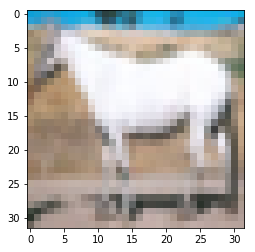

In [45]:
test_image = x_test[test_idx]
plt.imshow(test_image)

In [46]:
# tensorflow expects multiple records, thus
# a 4th dimension
test_image = test_image.reshape(1, 32, 32, 3)

In [47]:
result = custom_model.predict(test_image)

In [48]:
print('Prediction:', CLASSES[result.argmax()])

print('Actual:    ', CLASSES[y_test[test_idx].argmax()])

Prediction: TRUCK
Actual:     HORSE
